In [2]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree 
from sklearn.ensemble import ExtraTreesClassifier      #- random trees 
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier 
from sklearn.ensemble import GradientBoostingClassifier #- GBM classfier

# -- we need this to make our pipeline 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
# -- categorical encoders -- 
#from category_encoders import *


# -- need this to render charts in notebook -- 
%matplotlib inline


In [3]:
#df = pd.read_csv(r"C:\Users\sean0\Downloads\new_subscribers.csv")
#phones = pd.read_csv(r"C:\Users\sean0\Downloads\phones.csv")
phones = pd.read_csv('./data/phones.csv').rename(columns={"product_id":"phone_id"})
df1 = pd.read_csv('./data/new_subscribers.csv')
df = pd.merge(df1, phones, on='phone_id', how='left')
df.head()

,total_lifetime_value,credit_score,shipping_amt,promo_discount,ip_address,avs_code,email_domain,user_agent,billing_postal,phone_id,...,event_timestamp,transaction_id,customer_name,billing_address,billing_state,email_name,phone_number,is_fraud,product_name,product_mfg
0,5899.0,647.0,71.0,267.0,6.58.107.44,Q,harrington-barrett.com,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,34630.0,130.0,...,2020-04-28 02:58:00,9.379067e+09,Stephanie Fletcher,89142 Smith Light Fake St.,VA,haley41,(220)631-5381,0,Samsung Galaxy S9 G960U 64GB Unlocked [Midnigh...,Samsung
1,4882.0,582.0,72.0,154.0,50.60.19.244,A,juarez-howard.com,Mozilla/5.0 (iPad; CPU iPad OS 4_2_1 like Mac ...,34293.0,140.0,...,2020-05-08 17:54:53,4.271059e+09,Rita Conley,8045 Taylor Camp Fake St.,UT,jennifergarcia,+1-636-156-6620x3320,0,Google Pixel 3 XL 64GB Unlocked GSM & CDMA 4G ...,Google
2,4871.0,624.0,55.0,253.0,195.253.71.163,C,butler.net,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_5_6) A...,32424.0,241.0,...,2020-01-01 21:34:21,2.856708e+09,Sophia Goodman,27185 Santos Common Fake St.,CO,edward79,+1-254-407-6887x778,0,"Motorola e5 Play 16GB Smartphone , Black",Motorola
3,6404.0,599.0,63.0,258.0,89.103.126.109,F,casey-thomas.com,Mozilla/5.0 (Windows; U; Windows NT 5.1) Apple...,32457.0,132.0,...,2019-12-13 07:21:42,5.797872e+09,Linda Ray,35490 Xavier Knolls Fake St.,ID,derekramirez,001-651-607-4678x1641,0,"OnePlus 7T HD1900 256GB, 8GB, Dual Sim, 6.55 i...",OnePlus
4,4530.0,572.0,56.0,251.0,45.247.92.14,F,meyer-flores.com,Mozilla/5.0 (iPod; U; CPU iPhone OS 4_3 like M...,32453.0,211.0,...,2019-10-11 18:54:24,9.983474e+09,Angela Davis,9478 Byrd Shore Fake St.,IN,rperez,4748914665,0,Samsung Galaxy S10 Lite Dual SIM 128GB 6GB RAM...,Samsung


In [4]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
    .str.replace('.','_')
)
print(df.columns)

Index(['total_lifetime_value', 'credit_score', 'shipping_amt',
       'promo_discount', 'ip_address', 'avs_code', 'email_domain',
       'user_agent', 'billing_postal', 'phone_id', 'phone_count',
       'phone_trade_in', 'phone_protection', 'contract_term', 'phone_plan',
       'accessory_count', 'event_timestamp', 'transaction_id', 'customer_name',
       'billing_address', 'billing_state', 'email_name', 'phone_number',
       'is_fraud', 'product_name', 'product_mfg'],
      dtype='object')


In [5]:
target = 'is_fraud'
excludes = ['event_timestamp', 'customer_name', 'billing_address', 'transaction_id', 'phone_number']

numeric_features = [x for x in df.select_dtypes(include=['float64', 'int64']).columns if x not in [target] + excludes]
print(numeric_features)
categorical_features = [x for x in df.select_dtypes(include=['object']).columns if x not in [target] + excludes] 
print(categorical_features)

['total_lifetime_value', 'credit_score', 'shipping_amt', 'promo_discount', 'billing_postal', 'phone_id', 'phone_count', 'accessory_count']
['ip_address', 'avs_code', 'email_domain', 'user_agent', 'phone_trade_in', 'phone_protection', 'contract_term', 'phone_plan', 'billing_state', 'email_name', 'product_name', 'product_mfg']


In [6]:
## fill in missing values
#df[numeric_features]     = df[numeric_features].fillna(-1)
#df[categorical_features] = df[categorical_features].astype('str').fillna('missing')
df.isnull().sum(axis = 0)


total_lifetime_value    39
credit_score            50
shipping_amt            44
promo_discount          47
ip_address              45
avs_code                41
email_domain            49
user_agent              51
billing_postal          46
phone_id                46
phone_count             46
phone_trade_in          48
phone_protection        38
contract_term           31
phone_plan              39
accessory_count         33
event_timestamp         44
transaction_id          46
customer_name           40
billing_address         39
billing_state           62
email_name              36
phone_number            40
is_fraud                 0
product_name            47
product_mfg             47
dtype: int64

In [7]:

train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))


train pct: 70.00%
test  pct: 30.00%


In [8]:
# -- define pipeline --
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore')) 
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1))
])

preprocessing = ColumnTransformer(transformers=[
    #('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

model_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', ExtraTreesClassifier())
])

model_pipeline.fit(train[numeric_features ], train[target].values)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=-1,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                               

In [25]:
print(np.linspace(0, 1, 101))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


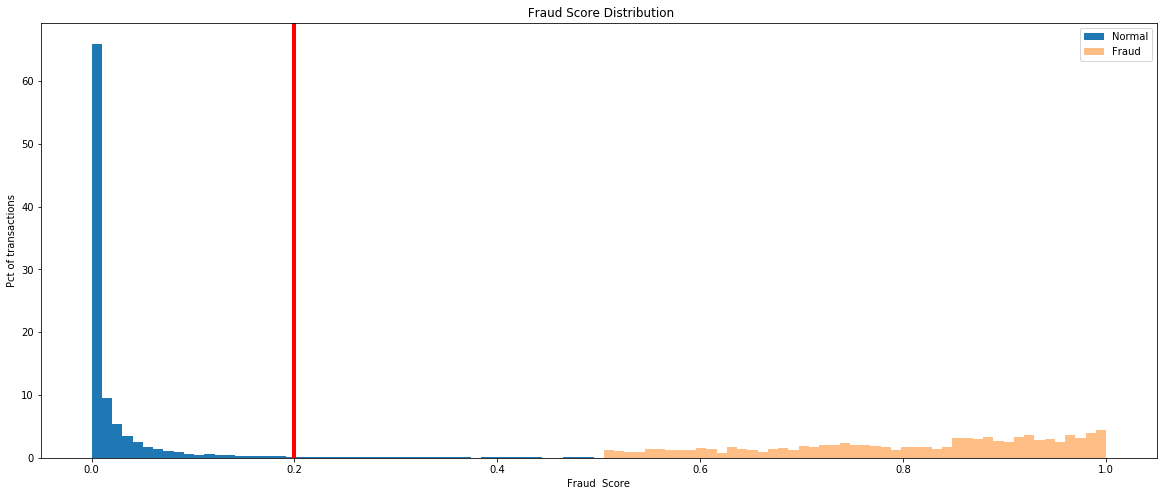

In [30]:
score_threshold = .100

test['score'] = model_pipeline.predict_proba(test[numeric_features])[:,1]
test["pred_is_fraud"] = model_pipeline.predict(test[numeric_features])

predicted_fraud = test.loc[test["pred_is_fraud"] == 1]
predicted_legit = test.loc[test["pred_is_fraud"] == 0]


#fraud = predictions.loc[predictions[FRAUD_LABEL] == 1 ]
#legit = predictions.loc[predictions[FRAUD_LABEL] == 0 ]

bins = np.linspace(0, 1, 100)
plt.figure(figsize=(20,8))
plt.hist(predicted_legit['score'].astype(float) , bins, alpha=1, density=True, label='Normal')

plt.hist(predicted_fraud['score'].astype(float) , bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title(" Fraud Score Distribution")
plt.xlabel("Fraud  Score")
plt.ylabel("Pct of transactions");
plt.axvline(x = 0.2 ,linewidth=4, color='r')
plt.show()



ip_address
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.1s finished


Best parameter (CV auc=0.796):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.947
AUC.     0.788
(Test):
Accuracy 0.947
AUC.     0.763


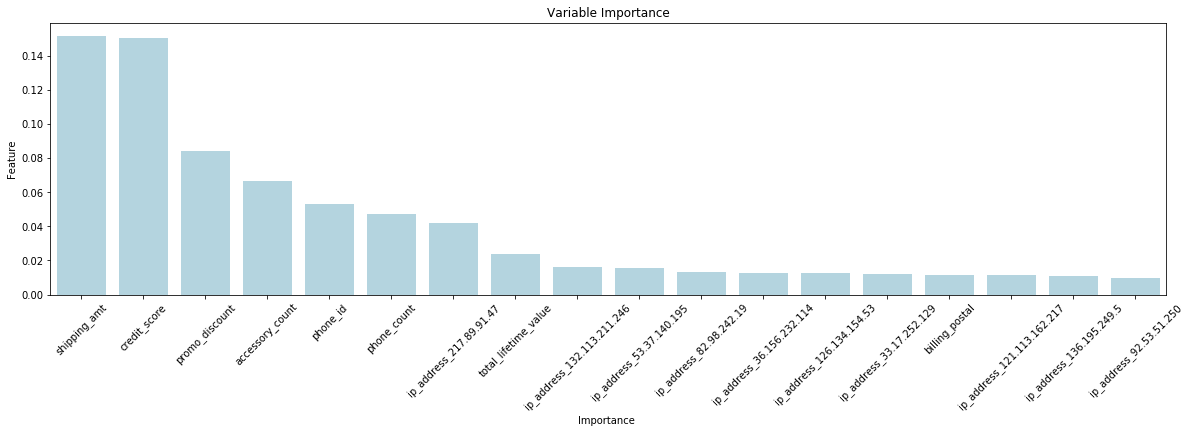

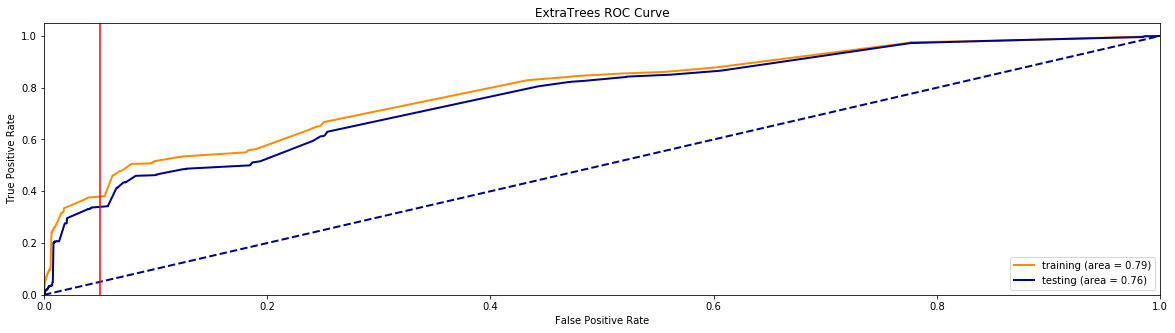

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.03       0.08
1  0.02  0.28       0.07
2  0.04  0.33       0.06


avs_code
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.2s finished


Best parameter (CV auc=0.928):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.949
AUC.     0.929
(Test):
Accuracy 0.949
AUC.     0.928


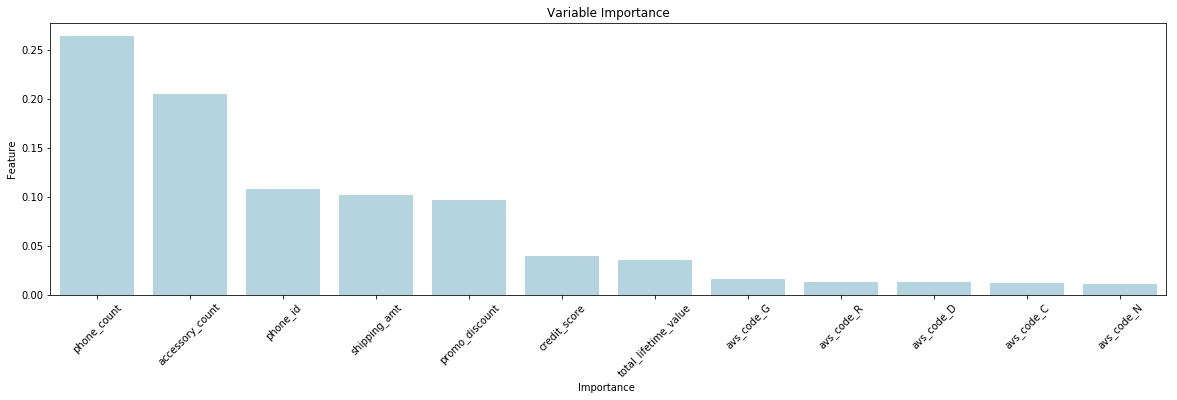

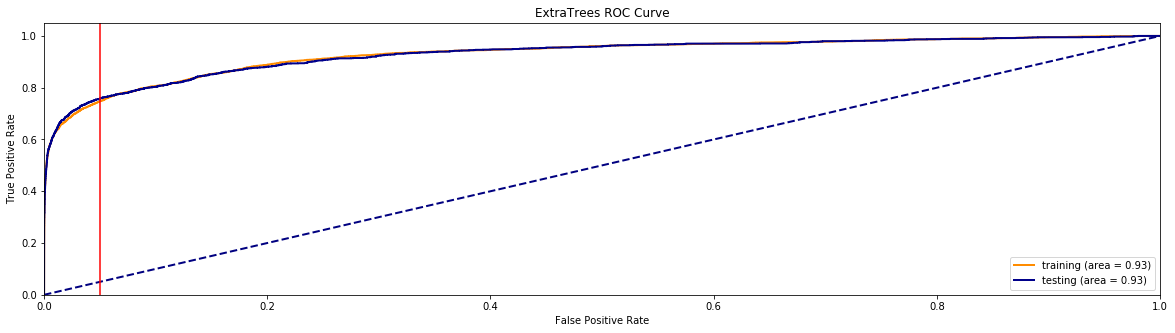

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.58       0.19
1  0.02  0.67       0.14
2  0.03  0.71       0.13
3  0.04  0.73       0.11
4  0.05  0.75       0.10


email_domain
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.0s finished


Best parameter (CV auc=0.799):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.947
AUC.     0.830
(Test):
Accuracy 0.947
AUC.     0.821


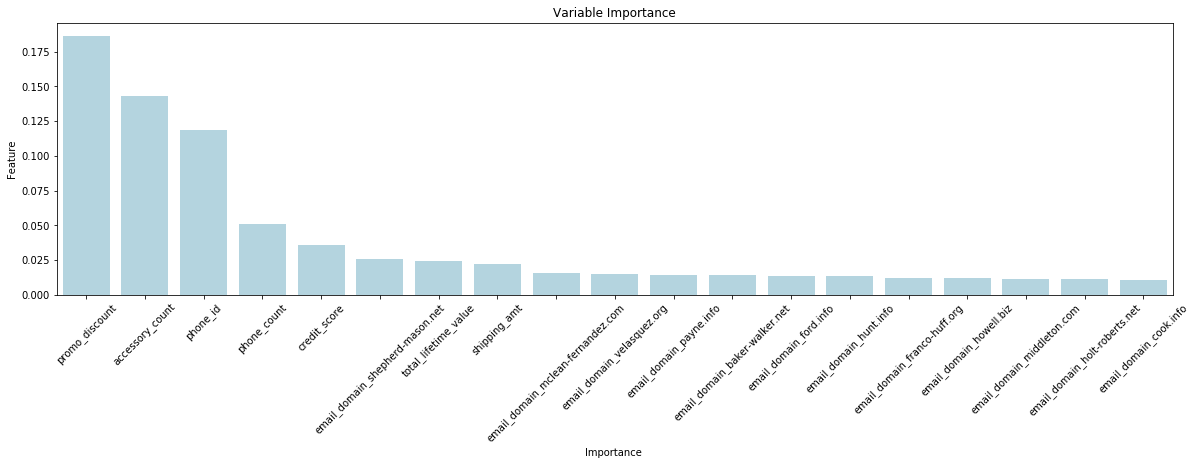

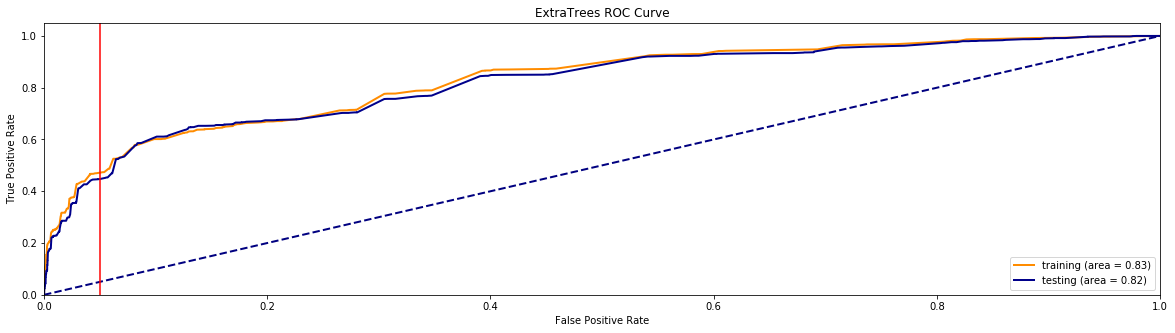

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.18       0.10
1  0.02  0.28       0.08
2  0.03  0.35       0.07
3  0.04  0.43       0.07
4  0.05  0.45       0.07


user_agent
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.9s finished


Best parameter (CV auc=0.811):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.947
AUC.     0.862
(Test):
Accuracy 0.947
AUC.     0.850


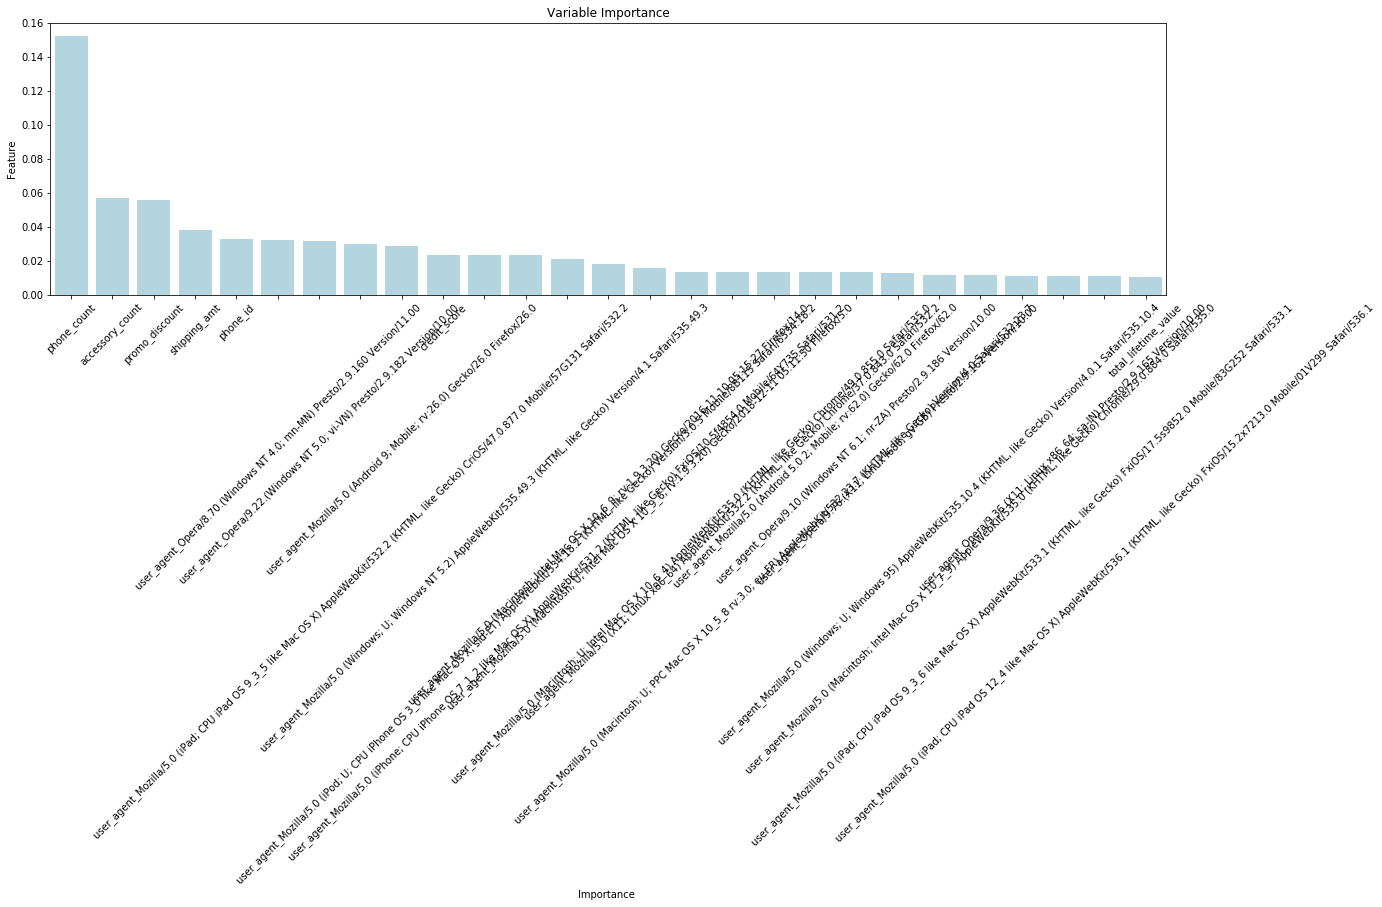

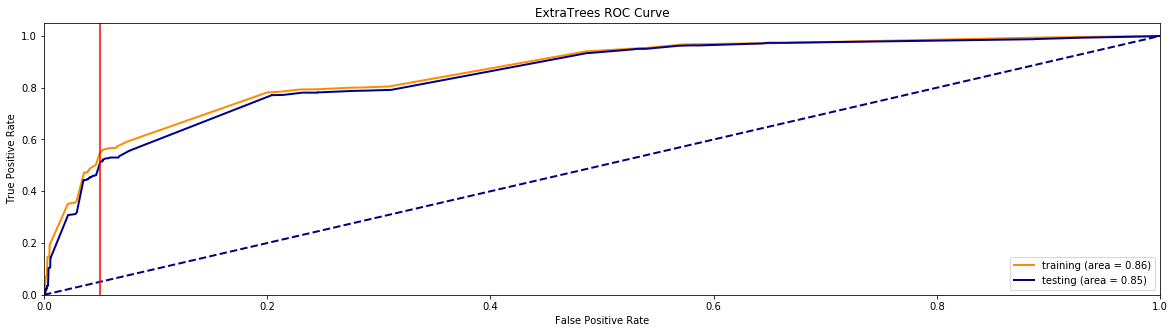

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.10       0.08
1  0.02  0.31       0.08
2  0.03  0.31       0.08
3  0.04  0.44       0.08
4  0.05  0.46       0.06


phone_trade_in
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.9s finished


Best parameter (CV auc=0.944):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.962
AUC.     0.950
(Test):
Accuracy 0.961
AUC.     0.946


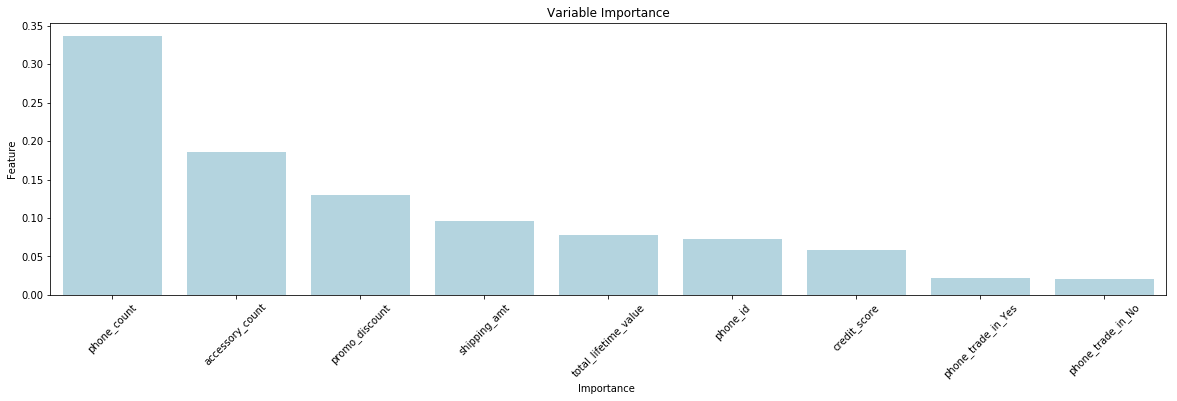

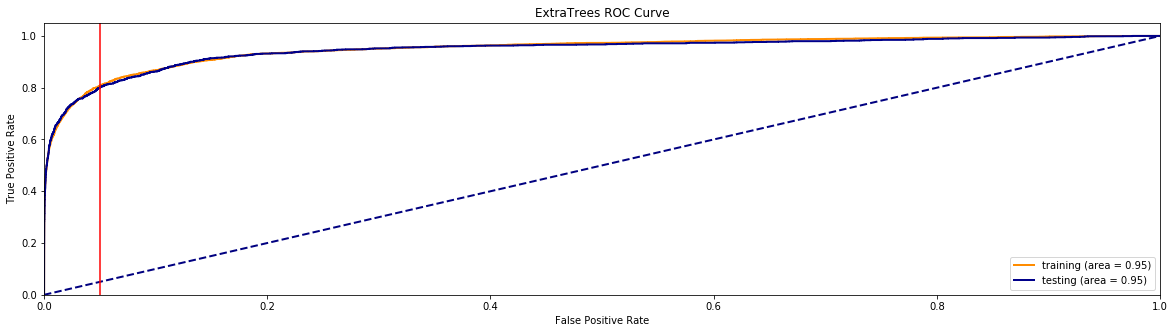

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.58       0.26
1  0.02  0.68       0.18
2  0.03  0.74       0.14
3  0.04  0.76       0.12
4  0.05  0.78       0.11


phone_protection
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.0s finished


Best parameter (CV auc=0.945):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.960
AUC.     0.954
(Test):
Accuracy 0.959
AUC.     0.952


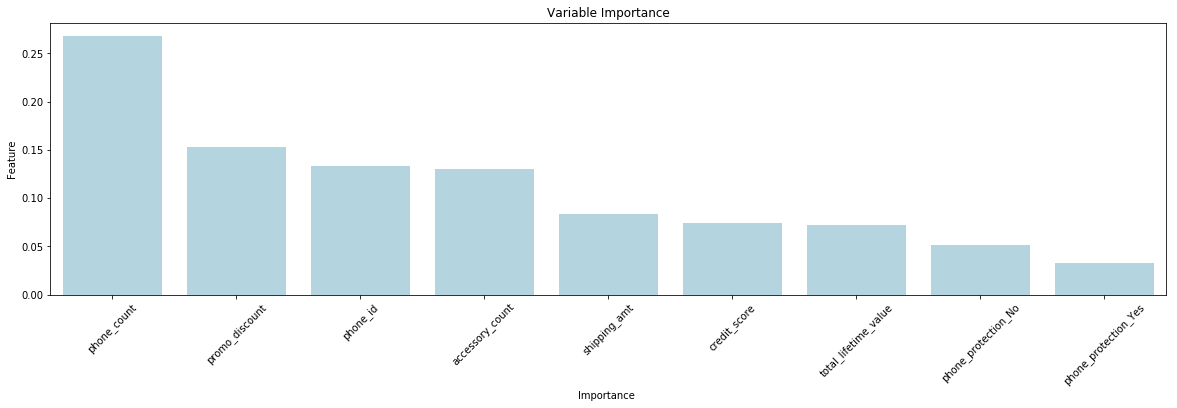

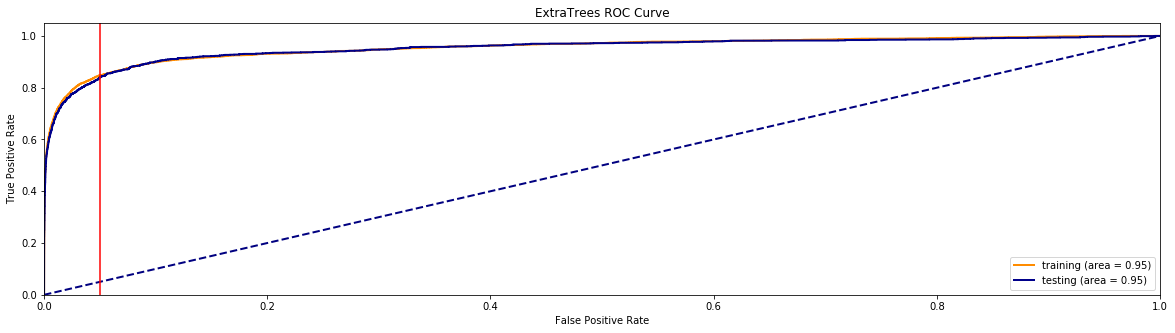

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.61       0.24
1  0.02  0.73       0.18
2  0.03  0.78       0.16
3  0.04  0.80       0.14
4  0.05  0.82       0.13


contract_term
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.6s finished


Best parameter (CV auc=0.934):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.952
AUC.     0.940
(Test):
Accuracy 0.952
AUC.     0.938


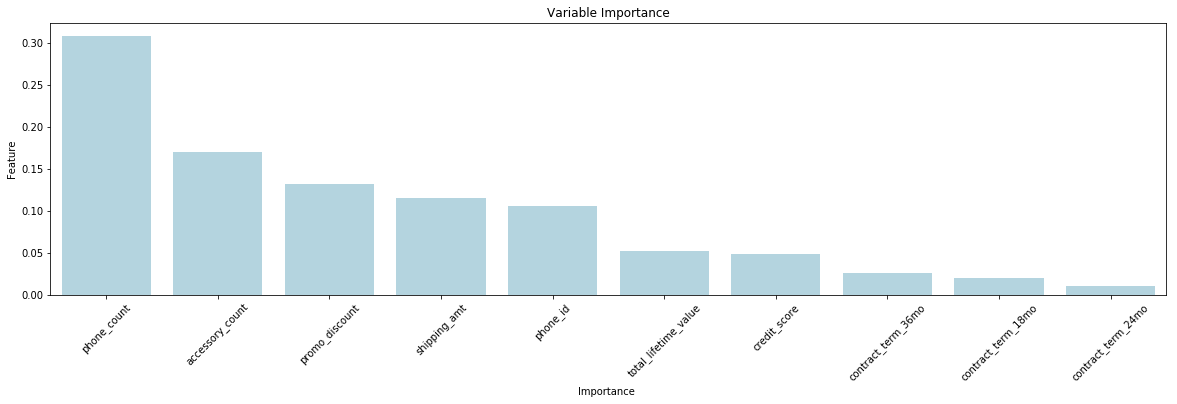

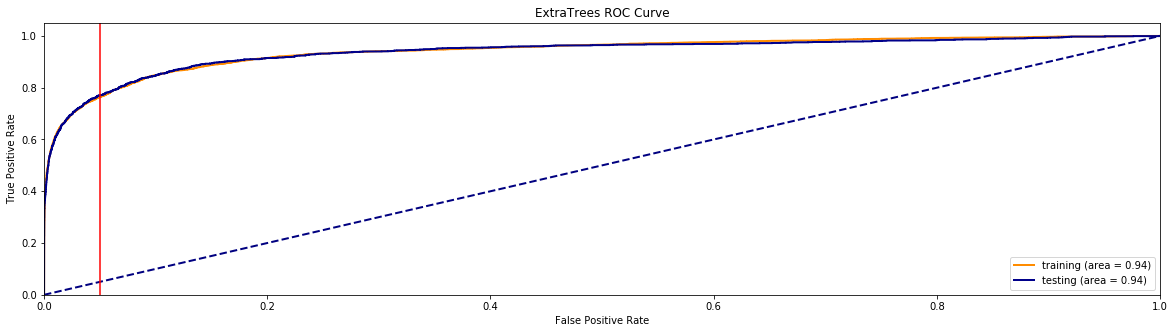

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.54       0.21
1  0.02  0.65       0.15
2  0.03  0.70       0.13
3  0.04  0.73       0.11
4  0.05  0.76       0.10


phone_plan
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.2s finished


Best parameter (CV auc=0.928):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.950
AUC.     0.923
(Test):
Accuracy 0.951
AUC.     0.921


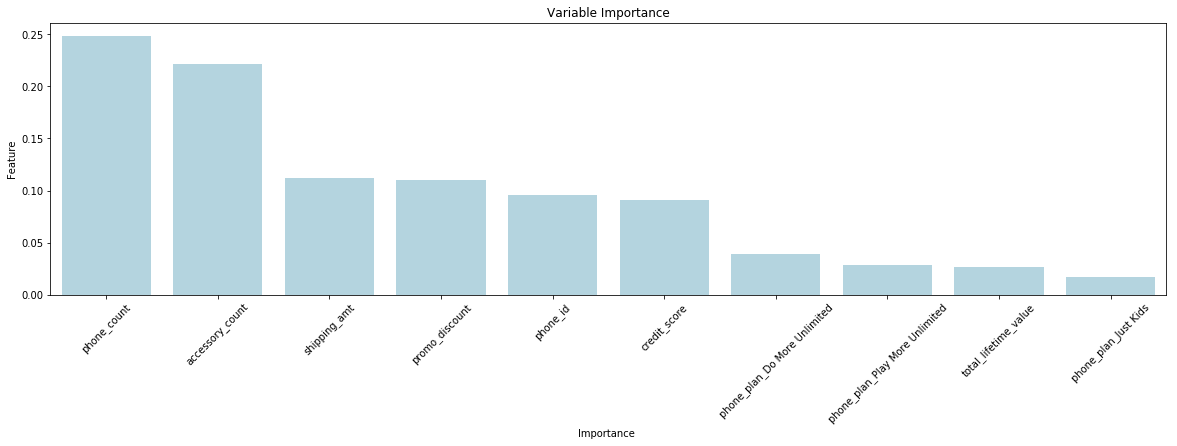

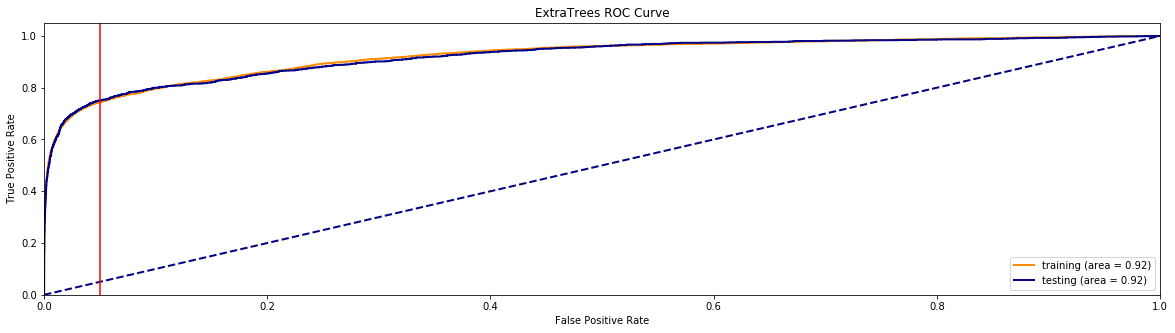

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.51       0.22
1  0.02  0.65       0.18
2  0.03  0.70       0.15
3  0.04  0.72       0.13
4  0.05  0.74       0.12


billing_state
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.5s finished


Best parameter (CV auc=0.902):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.947
AUC.     0.917
(Test):
Accuracy 0.947
AUC.     0.908


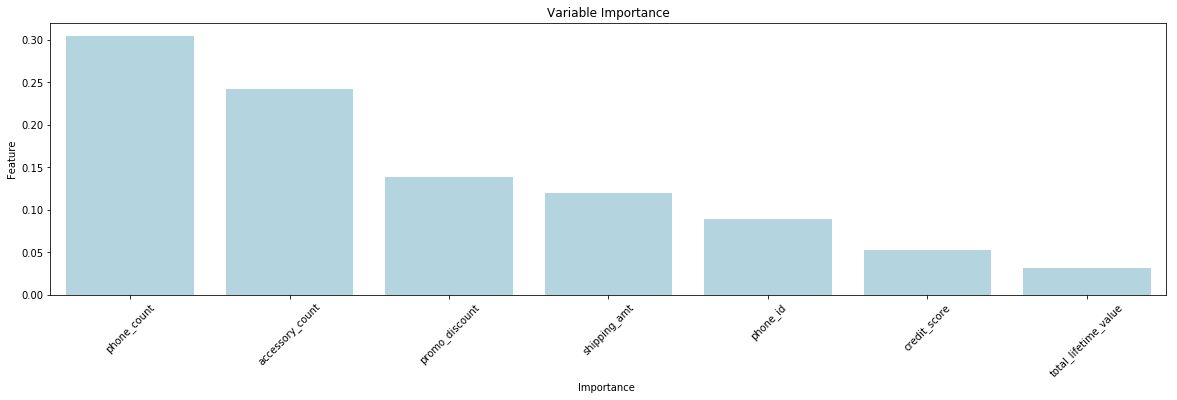

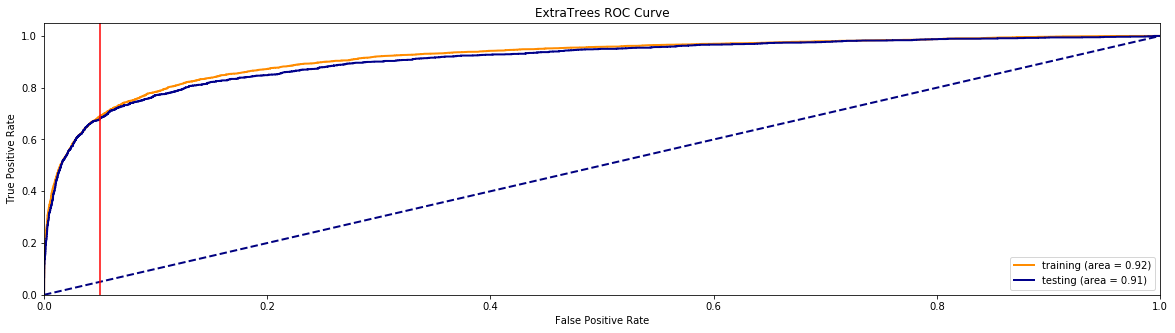

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.32       0.15
1  0.02  0.49       0.11
2  0.03  0.57       0.10
3  0.04  0.63       0.09
4  0.05  0.67       0.08


email_name
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.1s finished


Best parameter (CV auc=0.618):
{'classifier__n_estimators': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 5}


--- Training & Test Performance ---
(Training):
Accuracy 0.947
AUC.     0.508
(Test):
Accuracy 0.947
AUC.     0.500


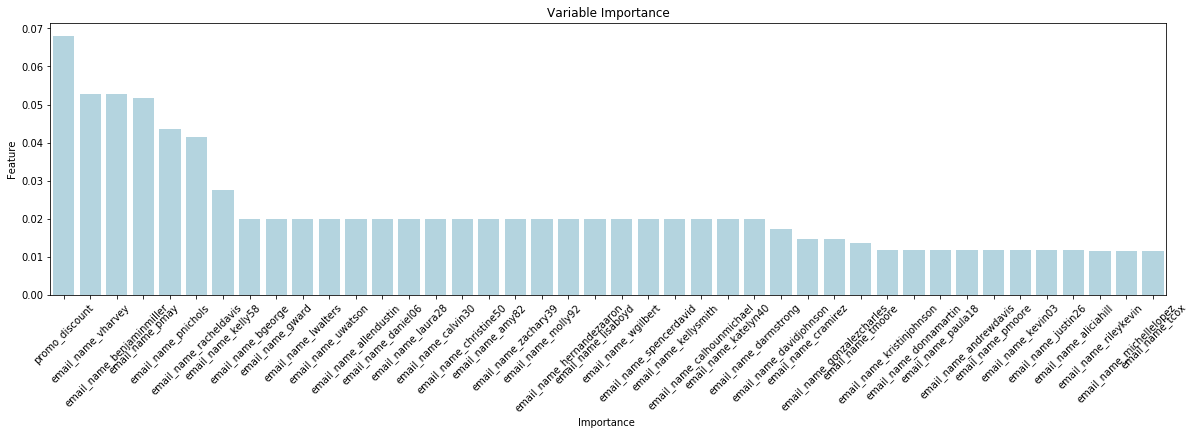

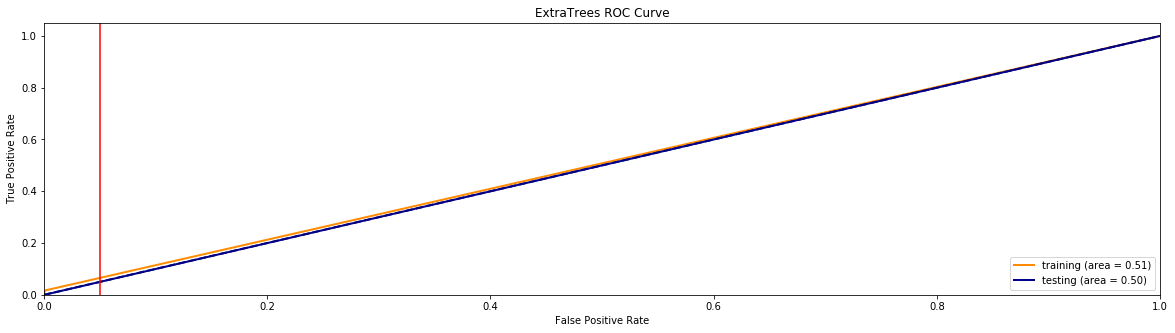

--- TEST score thresholds ---
Empty DataFrame
Columns: [fpr, tpr, threshold]
Index: []


product_name
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.0s finished


Best parameter (CV auc=0.876):
{'classifier__n_estimators': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.947
AUC.     0.859
(Test):
Accuracy 0.947
AUC.     0.848


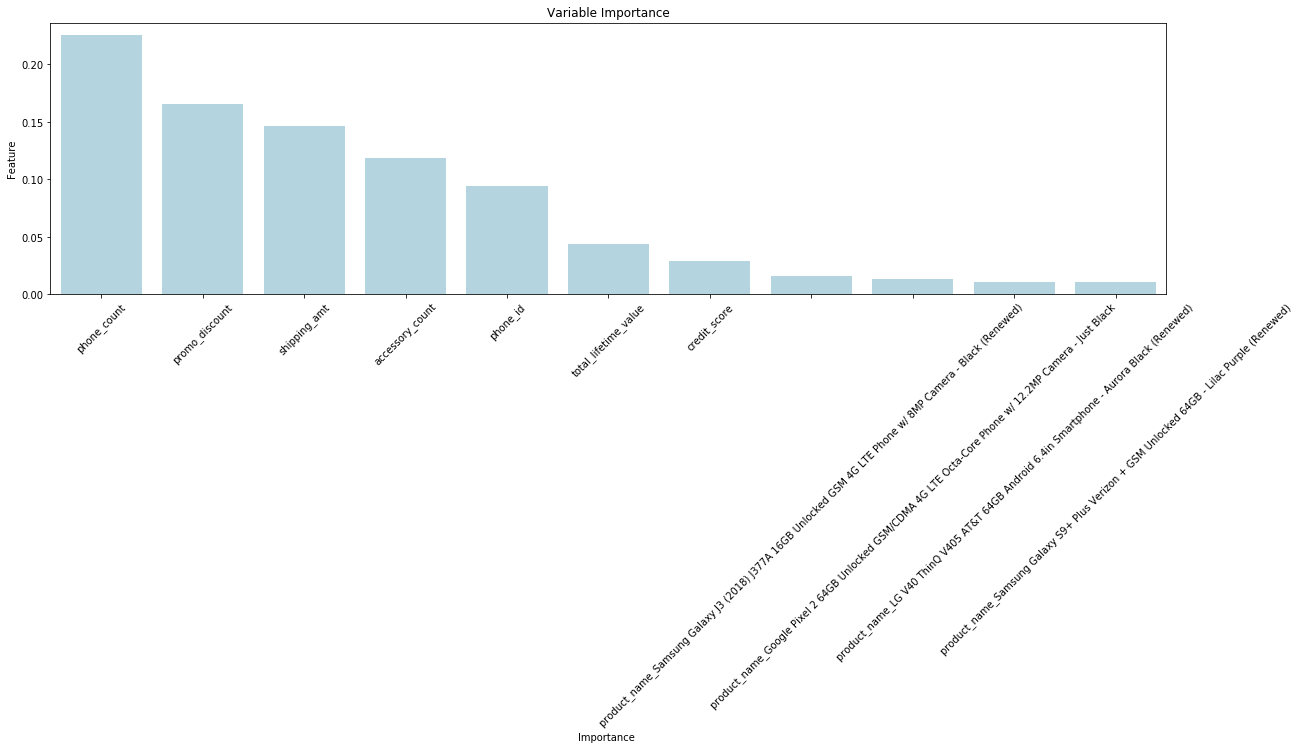

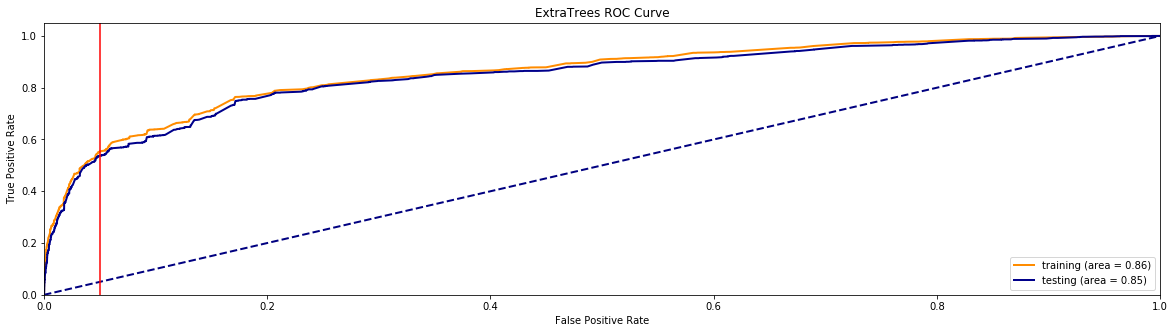

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.21       0.11
1  0.02  0.32       0.09
2  0.03  0.42       0.08
3  0.04  0.49       0.08
4  0.05  0.52       0.07


product_mfg
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.8s finished


Best parameter (CV auc=0.919):
{'classifier__n_estimators': 15, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.948
AUC.     0.922
(Test):
Accuracy 0.948
AUC.     0.917


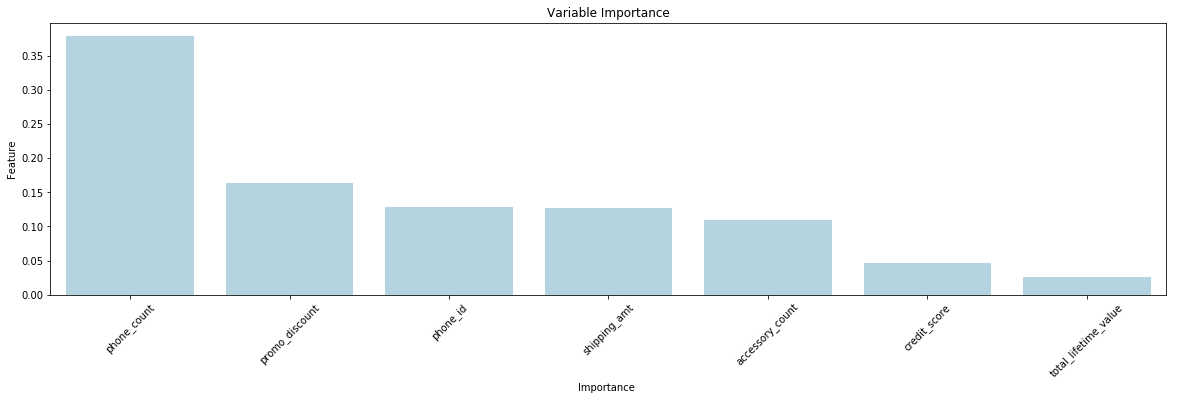

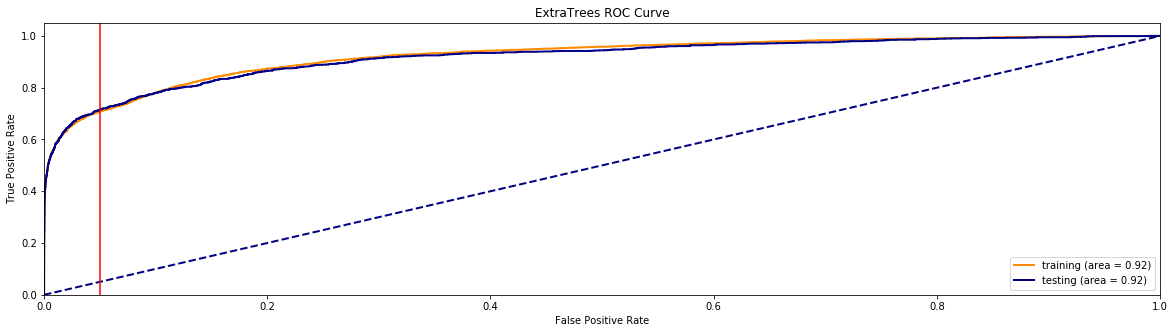

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.52       0.20
1  0.02  0.61       0.15
2  0.03  0.66       0.13
3  0.04  0.69       0.11
4  0.05  0.71       0.10




In [7]:
cat_feature = [x for x in df.select_dtypes(include=['object']).columns if x not in  [target] + excludes]

for cat in cat_feature:
    print(cat)
    categorical_features = [cat]
    def model_et_fit(param_grid):

        # -- define pipeline --
        categorical_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot',  OneHotEncoder(handle_unknown='ignore')) 
        ])

        numerical_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1))
        ])

        preprocessing = ColumnTransformer(transformers=[
            ('cat', categorical_pipe, categorical_features),
            ('num', numerical_pipe, numeric_features)
            ])

        model_pipeline = Pipeline([
            ('preprocess', preprocessing),
            ('classifier', ExtraTreesClassifier())
        ])


        # -- setup grid search -- 
        et_model = RandomizedSearchCV(model_pipeline, param_grid, n_jobs=-1, verbose=3, cv=5, scoring="roc_auc", refit=True)
        # -- fit grid search --
        et_model.fit(train[numeric_features + categorical_features], train[target].values)
        # -- print results -- 
        print("Best parameter (CV auc=%0.3f):" % et_model.best_score_)
        print(et_model.best_params_)
        print("\n")

        # -- assess best model, notice refit=True -- 
        train['.pred'] = et_model.predict(train[numeric_features + categorical_features])
        train_probabilites = et_model.predict_proba(train[numeric_features + categorical_features])
        train_fpr, train_tpr, train_thr= roc_curve(train[target], train_probabilites[:,1])

        print("--- Training & Test Performance ---")
        print("(Training):")
        print("Accuracy %0.3f" % accuracy_score(train[target], train['.pred']))
        print("AUC.     %0.3f" % auc(train_fpr,train_tpr))

        test['.pred'] = et_model.predict(test[numeric_features + categorical_features])
        test_probabilites = et_model.predict_proba(test[numeric_features + categorical_features])
        test_fpr, test_tpr, test_thr = roc_curve(test[target], test_probabilites[:,1])

        print("(Test):")
        print("Accuracy %0.3f" % accuracy_score(test[target], test['.pred']))
        print("AUC.     %0.3f" % auc(test_fpr,test_tpr))

        importance =  et_model.best_estimator_.named_steps["classifier"].feature_importances_

        categorical_pipe.fit_transform(train[categorical_features])
        transformed_categorical = categorical_pipe['onehot'].get_feature_names(categorical_features).tolist()

        # -- creates one list of all the feature names. 
        feature_names =  transformed_categorical + numeric_features


        feature_imp ={}
        for i,v in enumerate(importance):
            feature_imp[feature_names[i]] = v

        feature_imp ={}
        for i,v in enumerate(importance):
            feature_imp[feature_names[i]] = v

         # make the dictionary a data frame 
        feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                             columns=['importance'])

        # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
        feature_imp = (feature_imp
                       .reset_index()
                       .rename(columns={'index':'feature'})
                       .sort_values('importance',ascending=False)
                       .query('importance > 0.01'))

        # -- plot that 
        plt.figure(figsize=(20,5))
        sns.barplot(y="importance", x="feature", data=feature_imp, color="lightblue")
        plt.title( 'Variable Importance')
        plt.ylabel('Feature')
        plt.xlabel('Importance ')
        plt.xticks(rotation=45)
        plt.show()

        # -- make ROC charts 
        #- 5. FPR from 1 - 5% 
        model_stat = pd.concat([
            pd.DataFrame(test_fpr).rename(columns={0:'fpr'}),
            pd.DataFrame(test_tpr).rename(columns={0:'tpr'}),
            pd.DataFrame(test_thr).rename(columns={0:'threshold'})
            ],axis=1
            ).round(decimals=2)

        # - just get 1% FPR increments o
        m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()]    

        #- 3. get auc and threshold for train and test 
        train_auc = auc( train_fpr, train_tpr)
        test_auc = auc(test_fpr, test_tpr)

        #- 6. plot
        plt.figure(figsize=(20, 5))
        plt.plot(train_fpr, train_tpr, color='darkorange',
                 lw=2, label='training (area = %0.2f)' % train_auc)
        plt.plot(test_fpr, test_tpr, color='darkblue',
                 lw=2, label='testing (area = %0.2f)' % test_auc)

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.axvline(x= 0.05,  color='r')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title( 'ExtraTrees ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

        print("--- TEST score thresholds ---")
        print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.05)].reset_index(drop=True))
        print("\n")


        return et_model     

    param_grid = {
                'classifier__n_estimators': [10,15],
                'classifier__max_depth': [5,10],
                'classifier__min_samples_leaf': [2,4]
        }

    et = model_et_fit(param_grid)